# Gauging $P$ Quality: Local Mock Cycle (LMC) vs. Local Two-level Cycle (L2C)
For constant $k$ (repetitive equations):
* Compare local two-level cycle and (local) mock cycle convergence rates to determine if $P$ is good or caliber needs to be increased.
* First approximation to $P = R^T$ where $R$ = SVD coarsening.

We compare $kh = 0$ with GS, 2/1 coarsening and $kh = 0.5$ with Kaczmarz, 4/2, 6/2 and 6/3 coarsening cases.

In [18]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import helmholtz.repetitive.coarsening_repetitive as hrc
import helmholtz.analysis.ideal
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import scipy.sparse
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize
from IPython.display import display_html 

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

def display_df_side_by_side(a, b, captions):
    # Calculate two-level cycle convergence rate vs. domain size.
    a_styler = a.style.set_table_attributes("style='display:inline'").set_caption(captions[0]).format(precision=2)
    b_styler = b.style.set_table_attributes("style='display:inline'").set_caption(captions[1]).format(precision=2)
    display_html(a_styler._repr_html_()+b_styler._repr_html_(), raw=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96 # 384 # 192 #96

# Fit wavelength to domain size.
kh = helmholtz.analysis.ideal.find_singular_kh("5-point", n)[0]
num_sweeps = 6
aggregate_size = 4
num_components = 2

# Repetitive framework.
repetitive = True
# Number of test vectors.
num_examples = 3

nu_values = np.arange(1, 7)
m_values = np.arange(2, 11, dtype=int)

print("kh", kh)

kh 0.5233853805513015


## Coarsening $R$ and LMC Rate

In [ ]:
def mock_conv_factor(kh, n, aggregate_size, num_components, num_sweeps: int = 5):
    # 'num_sweeps': number of relaxation sweeps to relax the TVs and to use in coarsening optimization
    # (determined by relaxation shrinkage).

    # Create fine-level matrix.
    a = hm.linalg.helmholtz_1d_operator(kh, n)
    # Use default Kacmzarz for kh != 0.
    level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    # For A*x=b cycle tests.
    b = np.random.random((a.shape[0], ))

    # Create relaxed vectors.
    x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
    b = np.zeros_like(x)
    x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
    #import helmholtz.analysis.ideal
    #x, _ = helmholtz.analysis.ideal.ideal_tv(a, 2)

    # Construct coarsening on an aggregate.
    x_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(x, offset, aggregate_size)
              for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()

    # Tile the same coarsening over all aggregates.
    r, s = hm.setup.coarsening_uniform.create_coarsening(x_aggregate_t, num_components)
    print("kh", kh, "a", aggregate_size, "nc", num_components, "#TV sweeps",
          num_sweeps, "#windows", x_aggregate_t.shape[0], "r", r, "s", s)

    # Calculate mock cycle convergence rate.
    mock_conv = pd.DataFrame(np.array([
        mock_conv_factor_for_domain_size(kh, r, aggregate_size, m * aggregate_size, nu_values)
        for m in m_values]),
            index=m_values, columns=nu_values)

    return r, mock_conv

def mock_conv_factor_for_domain_size(kh, r, aggregate_size, m, nu_values):
    """Returns thre mock cycle conv factor for a domain of size m instead of n."""
    # Create fine-level matrix.
    a = hm.linalg.helmholtz_1d_operator(kh, m)
    # Use default Kacmzarz for kh != 0.
    level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    r_csr = hm.linalg.tile_array(r, m // aggregate_size)
    return np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, r_csr, nu) for nu in nu_values])

def create_two_level_hiearchy(kh, m, r, p):
    a = hm.linalg.helmholtz_1d_operator(kh, m)
    r_csr = hm.linalg.tile_array(r, m // aggregate_size)
    p_csr = hm.linalg.tile_array(p, m // aggregate_size)
    level0 = hm.setup.hierarchy.create_finest_level(a) #, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    level1 = hm.setup.hierarchy.create_coarse_level(level0.a, level0.b, r_csr, p_csr)
    multilevel = hm.hierarchy.multilevel.Multilevel.create(level0)
    multilevel.add(level1)
    return multilevel

def two_level_conv_factor(multilevel, nu, print_frequency: int = None):
    level = multilevel.finest_level
    n = level.size
    # Test two-level cycle convergence for A*x=b with random b.
    b = np.random.random((n, ))
    two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 0, nu_coarsest=-1, debug=False, rhs=b).run(y)
    residual = lambda x: b - multilevel[0].operator(x)
    return hm.solve.run.run_iterative_method(
        residual, two_level_cycle, np.random.random((n, )), 15, print_frequency=print_frequency)

def two_level_conv_data_frame(kh, r, p, aggregate_size, m_values, nu_values):
    return pd.DataFrame(np.array([
        [two_level_conv_factor(create_two_level_hiearchy(kh, m * aggregate_size, r, p), nu)[1]
         for nu in nu_values]
        for m in m_values]),
            index=m_values, columns=nu_values)

In [9]:
# cases = [
#     (0, 2, 1, 5),      # Laplace
#     (0.5, 4, 2, 5),    # kh=0.5, 4/2
#     (0.5, 6, 3, 5),    # kh=0.5, 6/3
#     (0.5, 6, 2, 5),    # kh=0.5, 6/2 (Karsten found it to be good)
#     (0.5, 6, 2, 200),    # kh=0.5, 6/2 (Karsten found it to be good)
# ]
# case_conv = [mock_conv_factor(*case) for case in cases]

In [10]:
r, mock_conv = mock_conv_factor(kh, n, aggregate_size, num_components, num_sweeps=num_sweeps)
mock_conv

kh 0.5233853805513012 a 4 nc 2 #TV sweeps 6 #windows 15 r [[-0.527 -0.659 -0.499 -0.196]
 [ 0.548  0.09  -0.414 -0.721]] s [0.203 0.158 0.042 0.01 ]


,1,2,3,4,5,6
2,0.37,0.20,0.10,0.05,0.03,0.03
3,0.44,0.26,0.10,0.09,0.06,0.06
4,0.45,0.26,0.12,0.13,0.10,0.06
5,0.47,0.26,0.13,0.13,0.11,0.05
6,0.45,0.23,0.13,0.12,0.11,0.07
7,0.47,0.26,0.13,0.13,0.10,0.07
8,0.46,0.26,0.13,0.13,0.11,0.07
9,0.49,0.24,0.13,0.13,0.11,0.07
10,0.49,0.26,0.15,0.13,0.12,0.07


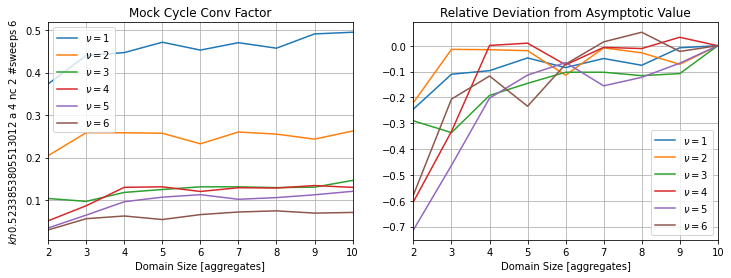

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

a, nc, conv = aggregate_size, num_components, mock_conv
# Mock cycle convergence vs. domain size [aggregates] and nu=1,...,6.
#print("kh {} a {} nc {} num_sweeps {}".format(kh, a, nc, num_sweeps))
#display(conv[:10])

ax_row = axs[row] if axs.ndim > 1 else axs
error = (conv - conv.iloc[-1]) / conv.iloc[-1]
#nu_values = conv.columns
#m_values = conv.index

ax = ax_row[0]
for nu in nu_values:
    ax.plot(m_values, conv[nu], label="$\\nu = {}$".format(nu))
ax.grid(True);
ax.set_xlim([2, 10]);
ax.set_xlabel("Domain Size [aggregates]")
ax.set_ylabel("$kh {}$ a {} nc {} #sweeps {}".format(kh, a, nc, num_sweeps))
ax.set_title("Mock Cycle Conv Factor");
ax.legend();

ax = ax_row[1]
for nu in nu_values:
    ax.plot(m_values, error[nu], label="$\\nu = {}$".format(nu))
ax.grid(True);
ax.set_xlim([2, 10]);
ax.set_xlabel("Domain Size [aggregates]")
ax.set_title("Relative Deviation from Asymptotic Value");
ax.legend();

$3-4$ aggregates are enough to show the mock cycle rate on the full domain.

## Two-level Cycle Rate with $P = R^T$

In [12]:
p = r.T
print(p)
#caliber = 1
# p = hm.setup.auto_setup.create_interpolation(
#     x_level, level.a, r, interpolation_method, aggregate_size=aggregate_size, nc=nc, max_caliber=max_caliber,
#     neighborhood=neighborhood, repetitive=repetitive, target_error=target_error)
# for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
#     error = norm(x_set - p.dot(r.dot(x_set)), axis=0) / norm(x_set, axis=0)
#     error_a = norm(level.a.dot(x_set - p.dot(r.dot(x_set))), axis=0) / norm(x_set, axis=0)
#     _LOGGER.info(
#         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
#             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

[[-0.527  0.548]
 [-0.659  0.09 ]
 [-0.499 -0.414]
 [-0.196 -0.721]]


### Solving $Ax = b$ - Convergence History

INFO         0 |r| 8.234e+00 RER 1.35846
INFO         1 |r| 1.603e+01 (1.94698) RER 0.18477 (0.13602) 86.761
INFO         2 |r| 2.770e+01 (1.72786) RER 0.10976 (0.59401) 252.370
INFO         3 |r| 5.806e+01 (2.09595) RER 0.09508 (0.86625) 610.623
INFO         4 |r| 1.230e+02 (2.11810) RER 0.08975 (0.94391) 1370.215
INFO         5 |r| 2.606e+02 (2.11895) RER 0.08742 (0.97407) 2980.699
INFO         6 |r| 5.523e+02 (2.11967) RER 0.08636 (0.98795) 6395.167
INFO         7 |r| 1.171e+03 (2.12044) RER 0.08588 (0.99434) 13637.755
INFO         8 |r| 2.484e+03 (2.12122) RER 0.08565 (0.99733) 29005.994
INFO         9 |r| 5.272e+03 (2.12204) RER 0.08554 (0.99873) 61629.890
INFO        10 |r| 1.119e+04 (2.12288) RER 0.08549 (0.99939) 130912.809
INFO        11 |r| 2.377e+04 (2.12374) RER 0.08546 (0.99970) 278109.399
INFO        12 |r| 5.050e+04 (2.12461) RER 0.08545 (0.99984) 590970.024
INFO        13 |r| 1.073e+05 (2.12550) RER 0.08544 (0.99991) 1256221.127
INFO        14 |r| 2.282e+05 (2.12638) RE

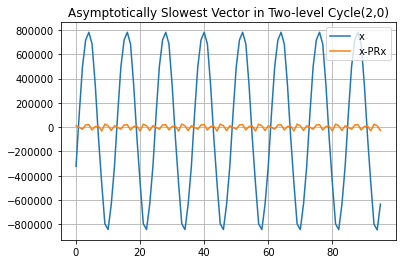

In [13]:
nu = 2
multilevel = create_two_level_hiearchy(kh, n, r, p)
y, _ = two_level_conv_factor(multilevel, nu, print_frequency=1)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

### Operators

In [14]:
display(pd.DataFrame(multilevel[0].a.todense()[:10,:10]))
display(pd.DataFrame(multilevel[1].r[:10,:10].todense()))
display(pd.DataFrame(multilevel[1].p[:10,:10].todense()))
display(pd.DataFrame(multilevel[1].a[:10,:10].todense()))

,0,1,2,3,4,5,6,7,8,9
0,-1.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,-1.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,1.00,-1.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,1.00,-1.73,1.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,1.00,-1.73,1.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,1.00,-1.73,1.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,1.00,-1.73,1.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,1.00,-1.73,1.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,-1.73,1.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,-1.73


,0,1,2,3,4,5,6,7,8,9
0,-0.53,-0.66,-0.50,-0.20,0.00,0.00,0.00,0.00,0.00,0.00
1,0.55,0.09,-0.41,-0.72,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.53,-0.66,-0.50,-0.20,0.00,0.00
3,0.00,0.00,0.00,0.00,0.55,0.09,-0.41,-0.72,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.53,-0.66
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.55,0.09
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9
0,-0.53,0.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.66,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.50,-0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.20,-0.72,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.53,0.55,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,-0.66,0.09,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,-0.50,-0.41,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,-0.20,-0.72,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,-0.53,0.55,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,-0.66,0.09,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9
0,-0.18,0.26,0.10,-0.11,0.00,0.00,0.00,0.00,0.00,0.00
1,0.26,-1.11,0.38,-0.40,0.00,0.00,0.00,0.00,0.00,0.00
2,0.10,0.38,-0.18,0.26,0.10,-0.11,0.00,0.00,0.00,0.00
3,-0.11,-0.40,0.26,-1.11,0.38,-0.40,0.00,0.00,0.00,0.00
4,0.00,0.00,0.10,0.38,-0.18,0.26,0.10,-0.11,0.00,0.00
5,0.00,0.00,-0.11,-0.40,0.26,-1.11,0.38,-0.40,0.00,0.00
6,0.00,0.00,0.00,0.00,0.10,0.38,-0.18,0.26,0.10,-0.11
7,0.00,0.00,0.00,0.00,-0.11,-0.40,0.26,-1.11,0.38,-0.40
8,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.38,-0.18,0.26
9,0.00,0.00,0.00,0.00,0.00,0.00,-0.11,-0.40,0.26,-1.11


### Level Operator Spectra

In [15]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [ 0.006  0.006 -0.063 -0.063  0.068  0.068  0.122  0.122 -0.139 -0.139  0.168  0.168]
1 lam [-0.005 -0.005  0.043  0.043 -0.066 -0.066  0.081  0.081  0.11   0.11   0.132  0.132]


### Local Two-level Cycle Rate

In [16]:
two_level_conv = two_level_conv_data_frame(kh, r, p, aggregate_size, m_values, nu_values)
display_df_side_by_side(mock_conv, two_level_conv, ['Mock Cycle', '2-level Cycle'])

,1,2,3,4,5,6
2,0.37,0.20,0.10,0.05,0.03,0.03
3,0.44,0.26,0.10,0.09,0.06,0.06
4,0.45,0.26,0.12,0.13,0.10,0.06
5,0.47,0.26,0.13,0.13,0.11,0.05
6,0.45,0.23,0.13,0.12,0.11,0.07
7,0.47,0.26,0.13,0.13,0.10,0.07
8,0.46,0.26,0.13,0.13,0.11,0.07
9,0.49,0.24,0.13,0.13,0.11,0.07
10,0.49,0.26,0.15,0.13,0.12,0.07
,1,2,3,4,5,6


* Again, looks like $3-4$ aggregates are sufficient to get a constant two-level rate, provided that $P$ is good enough (i.e. (a) TVs are sufficiently smooth -- in this $n=96$ domain case, passed $80$ relaxation sweeps, and (b) the caliber is sufficiently large).
* $P = R^T$ does not attain the mock cycle rates beyond $\nu=2, ACF \approx 0.4$.

## Convergence Rates after Bootstrapping

In [17]:
two_level_conv = two_level_conv_data_frame(kh, r, p, aggregate_size, m_values, nu_values)
display_df_side_by_side(mock_conv, two_level_conv, ['Mock Cycle', '2-level Cycle'])

max_levels = 2
num_bootstrap_steps = 2

# Create initial relaxed TVs.
a = hm.linalg.helmholtz_1d_operator(kh, n)
level = hm.setup.hierarchy.create_finest_level(a)
multilevel = hm.hierarchy.multilevel.Multilevel.create(level)
x = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
b = np.zeros_like(x)
x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method="svd", 
        neighborhood="aggregate", repetitive=repetitive, 
        target_error=0.1, aggregate_size=aggregate_size)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)
    coarse_level = multilevel[1]
    r = np.array(coarse_level.r[:num_components, :aggregate_size].todense())
    p = np.array(coarse_level.p[:aggregate_size, :num_components].todense())
    two_level_conv = two_level_conv_data_frame(kh, r, p, aggregate_size, m_values, nu_values)
    display_df_side_by_side(mock_conv, two_level_conv, ['Mock Cycle', '2-level Cycle'])

,1,2,3,4,5,6
2,0.37,0.20,0.10,0.05,0.03,0.03
3,0.44,0.26,0.10,0.09,0.06,0.06
4,0.45,0.26,0.12,0.13,0.10,0.06
5,0.47,0.26,0.13,0.13,0.11,0.05
6,0.45,0.23,0.13,0.12,0.11,0.07
7,0.47,0.26,0.13,0.13,0.10,0.07
8,0.46,0.26,0.13,0.13,0.11,0.07
9,0.49,0.24,0.13,0.13,0.11,0.07
10,0.49,0.26,0.15,0.13,0.12,0.07
,1,2,3,4,5,6


INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/2
INFO     Relax cycle conv factor 0.899 asymptotic RQ 0.072 RER 0.154 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.0966; mock cycle num_sweeps 6 conv 0.08 eff 0.81
INFO     Mock cycle conv factor [0.527 0.274 0.167 0.079] for nu [1 2 3 6]
INFO     all  set size 3  P L2 error mean 0.08 max 0.10 A error mean 0.22 max 0.28
INFO     Level 1 size 48
INFO     RER 0.150081
INFO     --------------------------------------------------------------------------------


,1,2,3,4,5,6
2,0.37,0.20,0.10,0.05,0.03,0.03
3,0.44,0.26,0.10,0.09,0.06,0.06
4,0.45,0.26,0.12,0.13,0.10,0.06
5,0.47,0.26,0.13,0.13,0.11,0.05
6,0.45,0.23,0.13,0.12,0.11,0.07
7,0.47,0.26,0.13,0.13,0.10,0.07
8,0.46,0.26,0.13,0.13,0.11,0.07
9,0.49,0.24,0.13,0.13,0.11,0.07
10,0.49,0.26,0.15,0.13,0.12,0.07
,1,2,3,4,5,6


INFO     Bootstrap step 2/2
INFO     Relax cycle conv factor 0.949 asymptotic RQ -0.008 RER 0.039 P error 0.044
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.0683; mock cycle num_sweeps 6 conv 0.08 eff 0.81
INFO     Mock cycle conv factor [0.529 0.275 0.163 0.077] for nu [1 2 3 6]
INFO     all  set size 3  P L2 error mean 0.04 max 0.05 A error mean 0.11 max 0.13
INFO     Level 1 size 48
INFO     RER 0.076224
INFO     --------------------------------------------------------------------------------


,1,2,3,4,5,6
2,0.37,0.20,0.10,0.05,0.03,0.03
3,0.44,0.26,0.10,0.09,0.06,0.06
4,0.45,0.26,0.12,0.13,0.10,0.06
5,0.47,0.26,0.13,0.13,0.11,0.05
6,0.45,0.23,0.13,0.12,0.11,0.07
7,0.47,0.26,0.13,0.13,0.10,0.07
8,0.46,0.26,0.13,0.13,0.11,0.07
9,0.49,0.24,0.13,0.13,0.11,0.07
10,0.49,0.26,0.15,0.13,0.12,0.07
,1,2,3,4,5,6


Even after bootstrap cycles, we do not get better than $ACF \approx 0.3$.